# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Streets with the Most Street Flooding Complaints

Author: Mark Bauer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
geopandas : 0.11.1
matplotlib: 3.5.2
seaborn   : 0.11.2



# Read in Data

In [3]:
# list items in data folder
%ls data/

README.md                       street-flooding-query.csv
street-flooding-complaints.csv  streets-clipped.gpkg


## Street Flooding Complaints

In [4]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

# preview data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,02 STATEN ISLAND,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':..."
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,03 STATEN ISLAND,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':..."
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,02 STATEN ISLAND,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'..."
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,05 QUEENS,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':..."
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,06 QUEENS,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'..."


In [5]:
# summarize columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24815 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   incident_zip                    24817 non-null  float64
 8   incident_address                16002 non-null  object 
 9   street_name                     16002 non-null  object 
 10  cross_street_1                  21821 non-null  object 
 11  cross_street_2                  21816 non-null  object 
 12  address_type                    

## Neighborhood Tabulation Areas (NTAs)

In [6]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_gdf = gpd.read_file(url)
nta_gdf = nta_gdf.to_crs(epsg=2263)

# previewing first five rows in data
print('shape of data: {}'.format(nta_gdf.shape[0]))
nta_gdf.head()

shape of data: 195


,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.847,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308..."
1,BX28,25666124.5948,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548..."
2,QN55,82461393.7368,081,South Ozone Park,36708.1693055,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819..."
3,BK50,82089678.6389,047,Canarsie,43703.6096661,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523..."
4,BX41,14716710.7402,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284..."


<AxesSubplot:>

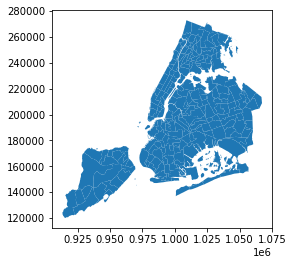

In [7]:
# sanity plot
nta_gdf.plot()

## Streets

In [8]:
path = 'data/streets-clipped.gpkg'
streets = gpd.read_file(path)

print('shape of data: {}'.format(streets.shape))
print('street id is unique: {}'.format(streets['physicalid'].is_unique))
print(streets.crs)

streets.head()

shape of data: (99124, 12)
street id is unique: True
epsg:2263


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99..."
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80..."
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26..."
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84..."
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69..."


In [9]:
# summarize columns
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99124 entries, 0 to 99123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99124 non-null  object  
 1   st_label      99124 non-null  object  
 2   st_name       99124 non-null  object  
 3   full_stree    99124 non-null  object  
 4   rw_type       99124 non-null  object  
 5   rw_type_name  99124 non-null  object  
 6   st_width      99124 non-null  object  
 7   frm_lvl_co    99124 non-null  object  
 8   to_lvl_co     99124 non-null  object  
 9   borocode      99124 non-null  object  
 10  shape_leng    99124 non-null  float64 
 11  geometry      99124 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [10]:
# examine counts of geom types
streets.geom_type.value_counts()

LineString    99124
dtype: int64

<AxesSubplot:>

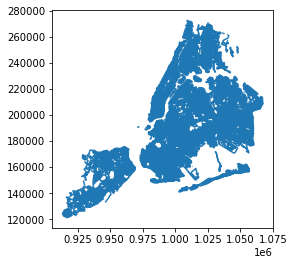

In [11]:
# sanity check plot
streets.plot()

# Assigning NTA Information to Street Complaints

In [12]:
# convert to geodataframe from x,y points
crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# make geodataframe
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# preview geodataframe
gdf.iloc[:, [0, -1]].head()

,unique_key,geometry
0,45283755,POINT (958363.000 148793.000)
1,45283863,POINT (937878.000 143517.000)
2,45279400,POINT (960864.000 149333.000)
3,45277773,POINT (1015410.000 201741.000)
4,45282532,POINT (1027498.000 202160.000)


<AxesSubplot:>

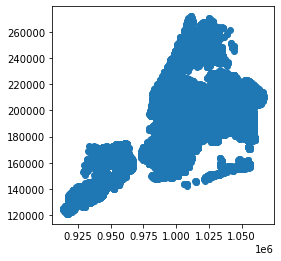

In [13]:
# sanity check plot
gdf.plot()

In [14]:
# spatial join nta to points
gdf = gpd.sjoin(
    gdf,
    nta_gdf,
    how="inner",
    predicate='within'
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (24814, 36)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,location,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,"{'latitude': '40.57522353925495', 'longitude':...",POINT (951437.000 148868.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,"{'latitude': '40.5817739850288', 'longitude': ...",POINT (954138.000 151251.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5


In [15]:
# summarize columns
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 24703
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24812 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   incident_zip                    24814 non-null  float64 
 8   incident_address                16002 non-null  object  
 9   street_name                     16002 non-null  object  
 10  cross_street_1                  21821 non-null  object  
 11  cross_street_2                  21816 non-null  object  
 12  address_ty

In [16]:
# exclude specified columns
cols = ['shape_leng', 'shape_area', 'index_right']
exclude = gdf.columns.isin(cols)

gdf = gdf.loc[:, gdf.columns[~exclude]]

# sanity check
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 24703
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24812 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   incident_zip                    24814 non-null  float64 
 8   incident_address                16002 non-null  object  
 9   street_name                     16002 non-null  object  
 10  cross_street_1                  21821 non-null  object  
 11  cross_street_2                  21816 non-null  object  
 12  address_ty

# Snap Complaints to Streets

Methodology: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

The code below is from Brendan's awesome post.

In [17]:
# offset of match (ft.)
offset = 80
bbox = gdf.bounds + [-offset, -offset, offset, offset]

# match points to streets based on distance
hits = bbox.apply(lambda row: list(streets.sindex.intersection(row)), axis=1)

print('shape of data: {}'.format(hits.shape))
hits.head(5)

shape of data: (24814,)


0            [78943, 78313, 78942, 56509]
9            [78943, 78313, 78942, 56509]
68    [90146, 54999, 95303, 55000, 90147]
79                                [98236]
80           [78943, 78313, 78942, 56509]
dtype: object

In [18]:
# position1: index of points table
# position2: ordinal position of line - access via iloc later
points_to_lines_dict = {
    'pt_idx': np.repeat(hits.index, hits.apply(len)),
    'line_i': np.concatenate(hits.values)
}
    
tmp = pd.DataFrame(points_to_lines_dict)
# join back to the lines on line_i
# join back to the original points to get their geometry, rename the point geometry as "point"
tmp = (
    tmp
    .join(streets, on="line_i")
    .join(gdf['geometry'].rename("point"), on="pt_idx")
)

print('shape of data: {}'.format(tmp.shape))
tmp.head()

shape of data: (82408, 15)


,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,0,78943.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ...",POINT (958363.000 148793.000)
1,0,78313.0,76094,MAPLETON AVE,MAPLETON,MAPLETON AVE,1,Street,18.0,13,13,5,251.356615,"LINESTRING (958315.407 148720.726, 958524.763 ...",POINT (958363.000 148793.000)
2,0,78942.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000)
3,0,56509.0,52063,NUGENT AVE,NUGENT,NUGENT AVE,1,Street,38.0,13,13,5,556.903050,"LINESTRING (958315.973 149159.852, 957997.235 ...",POINT (958363.000 148793.000)
4,9,78943.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ...",POINT (958363.000 148793.000)


In [19]:
# convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp,
    geometry='geometry',
    crs=gdf.crs
)

print('shape of data: {}'.format(tmp.shape))
tmp.head()

shape of data: (82408, 15)


,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,0,78943.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ...",POINT (958363.000 148793.000)
1,0,78313.0,76094,MAPLETON AVE,MAPLETON,MAPLETON AVE,1,Street,18.0,13,13,5,251.356615,"LINESTRING (958315.407 148720.726, 958524.763 ...",POINT (958363.000 148793.000)
2,0,78942.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000)
3,0,56509.0,52063,NUGENT AVE,NUGENT,NUGENT AVE,1,Street,38.0,13,13,5,556.903050,"LINESTRING (958315.973 149159.852, 957997.235 ...",POINT (958363.000 148793.000)
4,9,78943.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ...",POINT (958363.000 148793.000)


In [20]:
# discard any lines that are greater than tolerance from points
# sort on ascending snap distance, so that closest goes to top
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

# sanity check distance ceiling
tmp.loc[:, ['snap_dist']].describe()

,snap_dist
count,67649.000000
mean,15.998275
std,23.749351
min,0.000003
25%,0.377549
50%,2.731226
75%,28.478873
max,79.996887


In [21]:
# group by the index of the points and take the first, which is the closest line 
closest = (
    tmp
    .groupby("pt_idx")
    .first()
)

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,78942.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273
1,87545.0,86900,GETZ AVE,GETZ,GETZ AVE,1,Street,54.0,13,13,5,359.306539,"LINESTRING (937877.973 143517.454, 937931.865 ...",POINT (937878.000 143517.000),0.041074
2,49371.0,44670,QUINCY AVE,QUINCY,QUINCY AVE,1,Street,24.0,13,13,5,151.499515,"LINESTRING (960927.392 149386.927, 960816.303 ...",POINT (960864.000 149333.000),3.560673
3,95619.0,95836,70 ST,70,70 ST,1,Street,30.0,13,13,4,813.495132,"LINESTRING (1015284.400 201942.938, 1015707.19...",POINT (1015410.000 201741.000),2.353387
4,9655.0,13720,71 AVE,71,71 AVE,1,Street,40.0,13,13,4,45.256196,"LINESTRING (1027487.293 202138.287, 1027497.95...",POINT (1027498.000 202160.000),0.339680


In [22]:
counts = gdf.shape[0] - closest.shape[0]
counts_perc = round((1 - (closest.shape[0] / gdf.shape[0])) * 100, 2)

print('Dropped {} rows or {}% of street flooding complaint points, \
which were more than 80 feet from the closest street center line.'.format(counts, counts_perc))

Dropped 86 rows or 0.35% of street flooding complaint points, which were more than 80 feet from the closest street center line.


In [23]:
# position of nearest point from start of the line and get new point location geometry
pos = closest['geometry'].project(gpd.GeoSeries(closest.point))
new_pts = closest['geometry'].interpolate(pos)

# create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,78942.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
1,87545.0,86900,GETZ AVE,GETZ,GETZ AVE,1,Street,54.0,13,13,5,359.306539,POINT (937878.041 143517.006),POINT (937878.000 143517.000),0.041074
2,49371.0,44670,QUINCY AVE,QUINCY,QUINCY AVE,1,Street,24.0,13,13,5,151.499515,POINT (960866.421 149330.389),POINT (960864.000 149333.000),3.560673
3,95619.0,95836,70 ST,70,70 ST,1,Street,30.0,13,13,4,813.495132,POINT (1015407.989 201739.777),POINT (1015410.000 201741.000),2.353387
4,9655.0,13720,71 AVE,71,71 AVE,1,Street,40.0,13,13,4,45.256196,POINT (1027497.693 202160.146),POINT (1027498.000 202160.000),0.339680


In [24]:
# summarize columns
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 24703
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24812 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   incident_zip                    24814 non-null  float64 
 8   incident_address                16002 non-null  object  
 9   street_name                     16002 non-null  object  
 10  cross_street_1                  21821 non-null  object  
 11  cross_street_2                  21816 non-null  object  
 12  address_ty

In [25]:
# join back to the original points and drop any that did not join
updated_points = (
    gdf
    .drop(columns=["geometry"])
    .join(snapped)
    .dropna(subset=["geometry"])
    .reset_index(drop=True)
)

updated_points.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
1,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
2,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,1,Street,30.0,13,13,5,204.368178,POINT (951439.252 148866.357),POINT (951437.000 148868.000),2.787056
3,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,1,Street,30.0,13,13,5,308.463539,POINT (954140.677 151248.949),POINT (954138.000 151251.000),3.372281
4,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273


Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

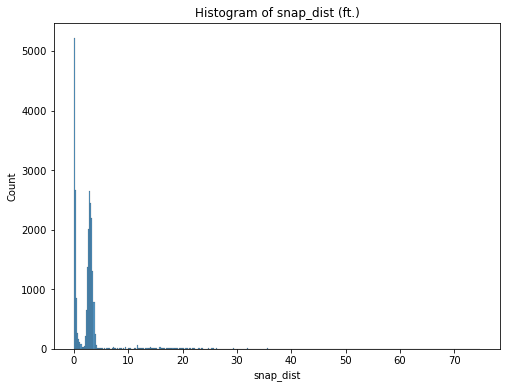

In [26]:
# distribution of snap distances
plt.figure(figsize=(8, 6))

sns.histplot(updated_points['snap_dist'])
plt.title('Histogram of snap_dist (ft.)')

In [27]:
# examine counts per street id
gdf_count = (
    updated_points
    .groupby(by='physicalid')['created_date']
    .count()
    .reset_index()
    .rename(columns={"created_date": "count"})
)

gdf_count.head()

,physicalid,count
0,100019,1
1,100020,1
2,10003,1
3,10004,2
4,100041,1


In [28]:
# join our street data to our flood complaints data
streets_with_count = streets.merge(
    gdf_count, 
    on='physicalid',
    how='left'
)

streets_with_count['count'] = streets_with_count['count'].fillna(0).astype(int)

print('shape of data: {}'.format(streets_with_count.shape))
streets_with_count.head()

shape of data: (99124, 13)


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99...",0
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80...",0
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26...",0
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84...",0
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69...",0


In [29]:
# summarize columns
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99124 entries, 0 to 99123
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99124 non-null  object  
 1   st_label      99124 non-null  object  
 2   st_name       99124 non-null  object  
 3   full_stree    99124 non-null  object  
 4   rw_type       99124 non-null  object  
 5   rw_type_name  99124 non-null  object  
 6   st_width      99124 non-null  object  
 7   frm_lvl_co    99124 non-null  object  
 8   to_lvl_co     99124 non-null  object  
 9   borocode      99124 non-null  object  
 10  shape_leng    99124 non-null  float64 
 11  geometry      99124 non-null  geometry
 12  count         99124 non-null  int64   
dtypes: float64(1), geometry(1), int64(1), object(10)
memory usage: 10.6+ MB


In [30]:
# examine highest counts
streets_with_count.sort_values(by='count', ascending=False).head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count
93336,93488,157 ST,157,157 ST,1,Street,35.0,13,13,4,499.593541,"LINESTRING (1045395.176 182129.994, 1045149.58...",91
49354,44654,MILL RD,MILL,MILL RD,1,Street,60.0,13,13,5,404.812271,"LINESTRING (952047.247 142027.744, 951842.023 ...",87
5436,109590,SAPPHIRE ST,SAPPHIRE,SAPPHIRE ST,1,Street,22.0,13,13,3,554.171435,"LINESTRING (1023856.014 183443.026, 1023962.36...",71
29929,23726,141 ST,141,141 ST,1,Street,30.0,13,13,4,678.504182,"LINESTRING (1039008.416 188480.641, 1039247.01...",71
84116,83475,BEDELL ST,BEDELL,BEDELL ST,1,Street,30.0,13,13,4,651.973881,"LINESTRING (1043449.919 189921.878, 1043959.01...",63


In [31]:
# normalize counts
streets_with_count['shape_leng'] = streets_with_count['geometry'].length
count_norm = (streets_with_count['count'] / streets_with_count['shape_leng'].replace(0, np.nan) * 100)

# counts per 100 ft
streets_with_count['count_per_100ft'] = round(count_norm, 2)

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count,count_per_100ft
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99...",0,0.0
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80...",0,0.0
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26...",0,0.0
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84...",0,0.0
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69...",0,0.0


In [32]:
# examine values
streets_with_count.loc[:, ['count_per_100ft']].describe()

,count_per_100ft
count,99124.000000
mean,0.095096
std,0.979144
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,228.670000


In [33]:
# sort descending
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count,count_per_100ft
12935,155472,W 228 ST,228,W 228 ST,1,Street,44.0,13,13,1,11.807495,"LINESTRING (1009588.318 258326.241, 1009580.18...",27,228.67
39266,3350,E 47 ST,47,E 47 ST,1,Street,45.0,13,13,1,36.576249,"LINESTRING (993217.323 213226.959, 993230.240 ...",19,51.95
8547,130213,E 68 ST,68,E 68 ST,1,Street,38.0,13,13,3,15.462558,"LINESTRING (1007289.058 166879.286, 1007298.11...",6,38.80
29209,22994,SHORE BLVD,SHORE,SHORE BLVD,1,Street,36.0,13,13,4,23.642131,"LINESTRING (1004233.755 222267.727, 1004218.39...",9,38.07
25962,199921,HERKIMER ST,HERKIMER,HERKIMER ST,1,Street,30.0,13,13,3,17.255823,"LINESTRING (1011761.619 185801.742, 1011768.20...",6,34.77


# Joining Streets and Counts to Neighborhoods

In [34]:
print('shape of data: {}'.format(updated_points.shape))
updated_points.head()

shape of data: (24728, 47)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
1,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
2,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,1,Street,30.0,13,13,5,204.368178,POINT (951439.252 148866.357),POINT (951437.000 148868.000),2.787056
3,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,1,Street,30.0,13,13,5,308.463539,POINT (954140.677 151248.949),POINT (954138.000 151251.000),3.372281
4,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273


In [35]:
# summarize columns
updated_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24728 entries, 0 to 24727
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24728 non-null  int64   
 1   created_date                    24728 non-null  object  
 2   closed_date                     24726 non-null  object  
 3   agency                          24728 non-null  object  
 4   agency_name                     24728 non-null  object  
 5   complaint_type                  24728 non-null  object  
 6   descriptor                      24728 non-null  object  
 7   incident_zip                    24728 non-null  float64 
 8   incident_address                15925 non-null  object  
 9   street_name                     15925 non-null  object  
 10  cross_street_1                  21737 non-null  object  
 11  cross_street_2                  21732 non-null  object  
 12  address_type      

In [36]:
# retrieve specific columns
cols = [
    'unique_key',
    'ntacode',
    'county_fips',
    'ntaname',
    'boro_name',
    'boro_code',
    'shape_leng',
    'physicalid'
]

streets_with_nta = updated_points.loc[:, cols]

streets_with_nta.head()

,unique_key,ntacode,county_fips,ntaname,boro_name,boro_code,shape_leng,physicalid
0,45283755,SI45,085,New Dorp-Midland Beach,Staten Island,5,372.785694,76941
1,45279697,SI45,085,New Dorp-Midland Beach,Staten Island,5,372.785694,76941
2,45196140,SI45,085,New Dorp-Midland Beach,Staten Island,5,204.368178,89719
3,45188340,SI45,085,New Dorp-Midland Beach,Staten Island,5,308.463539,98849
4,45188337,SI45,085,New Dorp-Midland Beach,Staten Island,5,372.785694,76941


In [37]:
# check for duplicates
checking_for_duplicates = (
    streets_with_nta
    .groupby(by=['physicalid', 'ntaname', 'boro_name'])['shape_leng']
    .count()
    .reset_index()
    .rename(columns={"shape_leng": "count_complaints"})
)

checking_for_duplicates.head()

,physicalid,ntaname,boro_name,count_complaints
0,100019,Lindenwood-Howard Beach,Queens,1
1,100020,Lindenwood-Howard Beach,Queens,1
2,10003,East Elmhurst,Queens,1
3,10004,East Elmhurst,Queens,2
4,100041,Queens Village,Queens,1


In [38]:
print('street id is unique: {}'.format(checking_for_duplicates['physicalid'].is_unique))

street id is unique: False


In [39]:
(checking_for_duplicates
 .loc[checking_for_duplicates.duplicated(subset=['physicalid'], keep=False) == True]
 .sort_values(by=['physicalid', 'count_complaints'], ascending=[True, False])
 .head(10)
)

,physicalid,ntaname,boro_name,count_complaints
153,101111,Lindenwood-Howard Beach,Queens,11
152,101111,East New York,Brooklyn,1
546,10779,Middle Village,Queens,1
547,10779,Ridgewood,Queens,1
562,109590,Lindenwood-Howard Beach,Queens,53
561,109590,East New York,Brooklyn,18
591,1128,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan,2
592,1128,Midtown-Midtown South,Manhattan,2
600,1134,Clinton,Manhattan,5
601,1134,Midtown-Midtown South,Manhattan,3


In [40]:
count_duplicates = (
    checking_for_duplicates
    .loc[checking_for_duplicates.duplicated(subset=['physicalid'], keep=False) == True]
    .shape[0]
)

counts = round(count_duplicates / streets_with_count.shape[0] * 100, 2)

print('count of duplicates: {:,}'.format(count_duplicates))
print('percent duplicates: {}%'.format(counts))

count of duplicates: 126
percent duplicates: 0.13%


In [41]:
# sorting descending by number of complaints on a street in a given NTA
# then removing duplicates
unique_streets = (
    checking_for_duplicates
    .sort_values(by=['physicalid', 'count_complaints'], ascending=[True, False])
    .drop_duplicates('physicalid')
    .reset_index(drop=True)
)

print('physical id is unique: {}'.format(unique_streets['physicalid'].is_unique))
unique_streets.head()

physical id is unique: True


,physicalid,ntaname,boro_name,count_complaints
0,100019,Lindenwood-Howard Beach,Queens,1
1,100020,Lindenwood-Howard Beach,Queens,1
2,10003,East Elmhurst,Queens,1
3,10004,East Elmhurst,Queens,2
4,100041,Queens Village,Queens,1


In [42]:
# joining streets with count complaints to unique streets
streets_with_count_nta = streets_with_count.merge(
    unique_streets, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

print('shape of data: {}'.format(streets_with_count_nta.shape))
streets_with_count_nta.head()

shape of data: (99124, 17)


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,count,count_per_100ft,ntaname,boro_name,count_complaints
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99...",0,0.0,NaN,NaN,NaN
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80...",0,0.0,NaN,NaN,NaN
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26...",0,0.0,NaN,NaN,NaN
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84...",0,0.0,NaN,NaN,NaN
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69...",0,0.0,NaN,NaN,NaN


In [43]:
# examine columns
streets_with_count_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99124 entries, 0 to 99123
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   physicalid        99124 non-null  object  
 1   st_label          99124 non-null  object  
 2   st_name           99124 non-null  object  
 3   full_stree        99124 non-null  object  
 4   rw_type           99124 non-null  object  
 5   rw_type_name      99124 non-null  object  
 6   st_width          99124 non-null  object  
 7   frm_lvl_co        99124 non-null  object  
 8   to_lvl_co         99124 non-null  object  
 9   borocode          99124 non-null  object  
 10  shape_leng        99124 non-null  float64 
 11  geometry          99124 non-null  geometry
 12  count             99124 non-null  int64   
 13  count_per_100ft   99124 non-null  float64 
 14  ntaname           11989 non-null  object  
 15  boro_name         11989 non-null  object  
 16  count_complain

In [44]:
# retrieve desired columns
cols = [
    'physicalid','full_stree', 'ntaname', 'boro_name',
    'count', 'count_per_100ft'
]

count_by_nta = (
    streets_with_count_nta
    .loc[:, cols]
    .reset_index(drop=True)
)

# sort on count desc
count_by_nta.sort_values(by='count', ascending=False).head()

,physicalid,full_stree,ntaname,boro_name,count,count_per_100ft
93336,93488,157 ST,Springfield Gardens South-Brookville,Queens,91,18.21
49354,44654,MILL RD,Oakwood-Oakwood Beach,Staten Island,87,21.49
5436,109590,SAPPHIRE ST,Lindenwood-Howard Beach,Queens,71,12.81
29929,23726,141 ST,Baisley Park,Queens,71,10.46
84116,83475,BEDELL ST,Baisley Park,Queens,63,9.66


In [45]:
# sort on count per 100ft desc
count_by_nta.sort_values(by='count_per_100ft', ascending=False).head()

,physicalid,full_stree,ntaname,boro_name,count,count_per_100ft
12935,155472,W 228 ST,Marble Hill-Inwood,Manhattan,27,228.67
39266,3350,E 47 ST,Turtle Bay-East Midtown,Manhattan,19,51.95
8547,130213,E 68 ST,Georgetown-Marine Park-Bergen Beach-Mill Basin,Brooklyn,6,38.80
29209,22994,SHORE BLVD,Old Astoria,Queens,9,38.07
25962,199921,HERKIMER ST,Ocean Hill,Brooklyn,6,34.77


In [46]:
# summary statistics
(streets_with_count
 .groupby(by=['physicalid', 'full_stree'])[['count', 'count_per_100ft']]
 .sum()
 .reset_index()
 .describe()
)

,count,count_per_100ft
count,99124.000000,99124.000000
mean,0.249465,0.095096
std,1.308244,0.979144
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,91.000000,228.670000


In [47]:
# Adding nta information
count_by_nta['ntaname_full'] = (
    count_by_nta['full_stree']
    + " (id: "
    + count_by_nta['physicalid']
    + "), " + count_by_nta['ntaname']
    + ", "
    + count_by_nta['boro_name']
)

count_by_nta.sort_values(by='count', ascending=False).head()

,physicalid,full_stree,ntaname,boro_name,count,count_per_100ft,ntaname_full
93336,93488,157 ST,Springfield Gardens South-Brookville,Queens,91,18.21,"157 ST (id: 93488), Springfield Gardens South-..."
49354,44654,MILL RD,Oakwood-Oakwood Beach,Staten Island,87,21.49,"MILL RD (id: 44654), Oakwood-Oakwood Beach, St..."
5436,109590,SAPPHIRE ST,Lindenwood-Howard Beach,Queens,71,12.81,"SAPPHIRE ST (id: 109590), Lindenwood-Howard Be..."
29929,23726,141 ST,Baisley Park,Queens,71,10.46,"141 ST (id: 23726), Baisley Park, Queens"
84116,83475,BEDELL ST,Baisley Park,Queens,63,9.66,"BEDELL ST (id: 83475), Baisley Park, Queens"


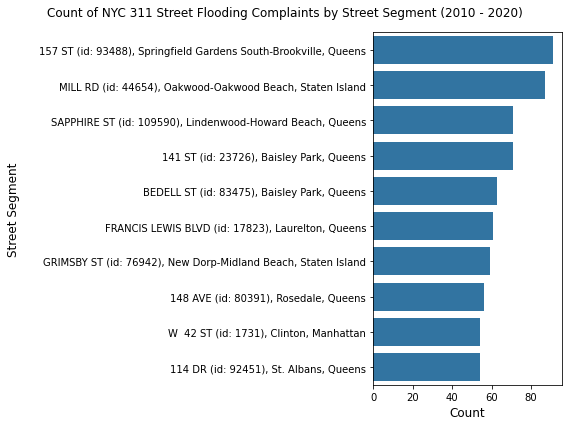

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

data = count_by_nta.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count',
    color='#1f77b4'
)

label = 'Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)'
fig.suptitle(label, fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Street Segment\n', fontsize=12)

plt.tight_layout()

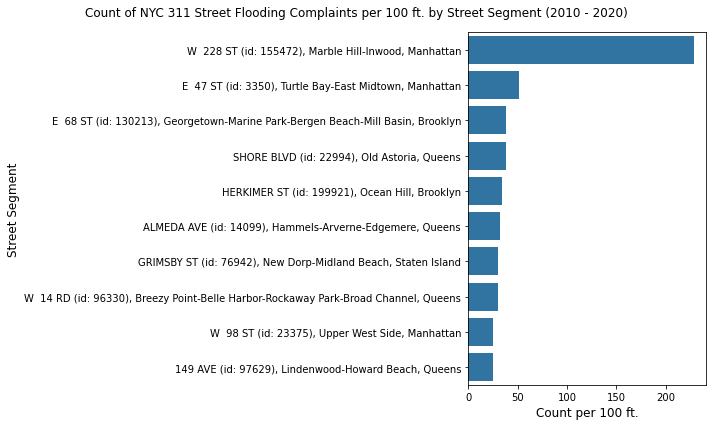

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

data = count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count_per_100ft',
    color='#1f77b4'
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)'
fig.suptitle(label, fontsize=12)
plt.xlabel('Count per 100 ft.', fontsize=12)
plt.ylabel('Street Segment', fontsize=12)

plt.tight_layout()

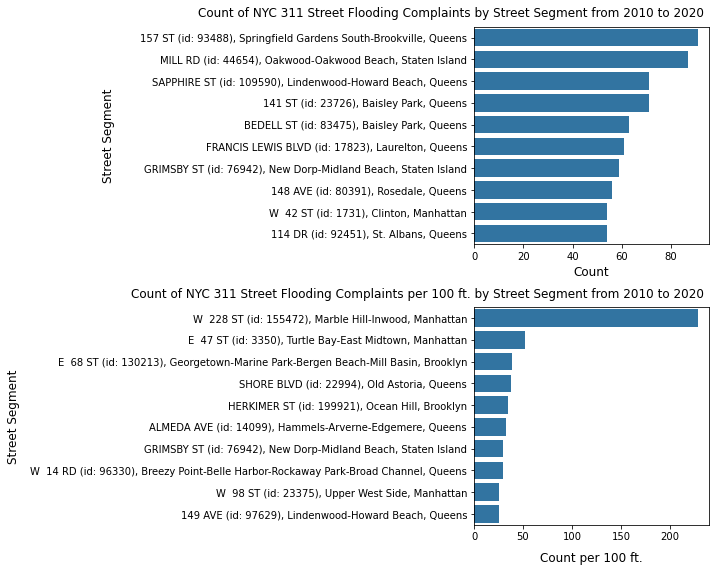

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# first plot
data = count_by_nta.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints by Street Segment from 2010 to 2020'
axs[0].set_title(label, fontsize=12, pad=10, x=-.1)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Street Segment\n', fontsize=12, labelpad=10)

# second plot
data = count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='ntaname_full',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment from 2010 to 2020'
axs[1].set_title(label, fontsize=12, pad=10, x=-.24)
axs[1].set_xlabel('Count per 100 ft.', fontsize=12, labelpad=10)
axs[1].set_ylabel('Street Segment', fontsize=12, labelpad=10)

fig.tight_layout(pad=.9)
plt.savefig('figures/count-street-segment.png', dpi=250, bbox_inches='tight')